# `qp` Demo

_Alex Malz & Phil Marshall_

In this notebook we use the `qp` module to approximate some simple, standard, 1-D PDFs using sets of quantiles, samples, and histograms, and assess their relative accuracy. We also show how such analyses can be extended to use "composite" PDFs made up of mixtures of standard distributions.

### Requirements

To run `qp`, you will need to first install the module. 

In [1]:
import numpy as np
import scipy.stats as sps
import scipy.interpolate as spi

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

import qp

## The `qp.PDF` Class

This is the basic element of `qp` - an object representing a probability density function. This class is stored in the module `pdf.py`.  The PDF must be initialized with some representation of the distribution.

In [2]:
# ! cat qp/pdf.py
P = qp.PDF()

## Approximating a Gaussian

Let's summon a PDF object, and initialize it with a standard function - a Gaussian.

<class 'scipy.stats._distn_infrastructure.rv_frozen'>
Plotted truth.


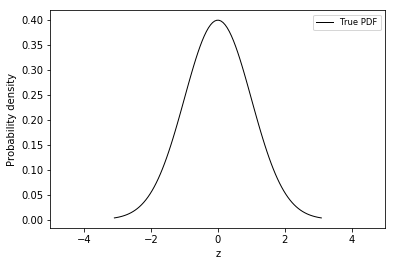

In [3]:
dist = sps.norm(loc=0, scale=1)
print(type(dist))
demo_limits = (-5., 5.)
P = qp.PDF(truth=dist, limits=demo_limits)
P.plot()

### Samples

Let's sample the PDF to see how it looks.  When we plot the `PDF` object, both the true and sampled distributions are displayed.

Created a KDE interpolator for the samples parametrization.
interpolating between -3.24126734007 and 3.85273149065 using samples
Plotted samples


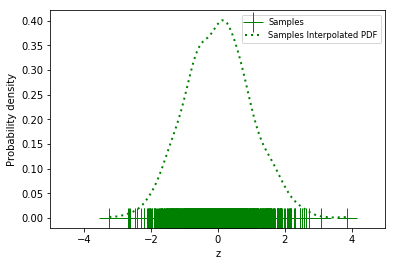

In [4]:
np.random.seed(42)

samples = P.sample(1000, using='truth', vb=False)
S = qp.PDF(samples=samples, limits=demo_limits)
S.plot()

### Quantile Parametrization

Now, let's compute a set of evenly spaced quantiles. These will be carried by the `PDF` object as `p.quantiles`.  We also demonstrate the initialization of a `PDF` object with quantiles and no truth function.

Calculating 10 quantiles: [ 0.09090909  0.18181818  0.27272727  0.36363636  0.45454545  0.54545455
  0.63636364  0.72727273  0.81818182  0.90909091]
Resulting 10 quantiles: [-1.33517774 -0.90845787 -0.60458535 -0.3487557  -0.11418529  0.11418529
  0.3487557   0.60458535  0.90845787  1.33517774]
interpolating between -1.33517773612 and 1.33517773612 using quantiles
interpolating between -5.0 and 5.0 using quantiles
Plotted quantiles.


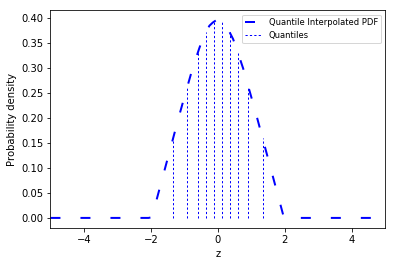

In [5]:
quantiles = P.quantize(N=10)
Q = qp.PDF(quantiles=quantiles, limits=demo_limits)
Q.plot()

### Histogram Parametrization

Let's also compute a histogram representation, that will be carried by the `PDF` object as `p.histogram`. The values in each bin are the integrals of the PDF over the range defined by bin ends. We can also initialize a `PDF` object with a histogram and no truth function.

Calculating histogram:  [-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.]
Result:  (array([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.,  4.,  5.]), array([  3.13846083e-05,   1.31822755e-03,   2.14002462e-02,
         1.35905200e-01,   3.41344942e-01,   3.41344942e-01,
         1.35905200e-01,   2.14002462e-02,   1.31822755e-03,
         3.13846083e-05]))
Created a piecewise constant interpolator for the histogram parametrization.
interpolating between -5.0 and 5.0 using histogram
Plotted histogram.
None


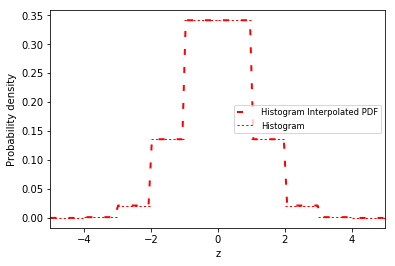

In [6]:
histogram = P.histogramize(N=10, binrange=demo_limits)
H = qp.PDF(histogram=histogram, limits=demo_limits)
H.plot()
print H.truth

### Evaluating the Approximate PDF by Interpolation

Once we have chosen a parametrization to approximate the PDF with, we can evaluate the approximate PDF at any point by interpolation (or extrapolation). `qp` uses [`scipy.intepolate.interp1d`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html) to do this, with `linear` as the default interpolation scheme. (Most other options do not enable extrapolation, `nearest` being the exception.)

Let's test this interpolation by evaluating an approximation at a single point using the quantile parametrization.

In [7]:
print P.approximate([0.314], using='quantiles')

interpolating between 0.314 and 0.314 using quantiles
([0.314], array([ 0.37671591]))


(We can also integrate any approximation.)

In [8]:
print P.integrate([0., 1.], using='quantiles')

interpolating between 0.0 and 1.0 using quantiles
0.33976198566


We can also interpolate the function onto an evenly spaced grid with points within and out of the quantile range, as follows:  

In [9]:
grid = np.linspace(-3., 3., 100)
gridded = P.approximate(grid, using='quantiles')

interpolating between -3.0 and 3.0 using quantiles


We can also change the interpolation scheme:

In [10]:
print P.scheme
print P.approximate([0.314], using='quantiles', scheme='nearest')
print P.scheme

linear
interpolating between 0.314 and 0.314 using quantiles
([0.314], array([ 0.38755568]))
nearest


### The "Evaluated" or "Gridded" Parametrization

A `qp.PDF` object may also be initialized with a parametrization of a function evaluated on a grid. This is also what is produced by the `qp.PDF.approximate()` method. So, let's take the output of a `qp.PDF` approximation evaluation, and use it to instantiate a new `qp.PDF` object. Note that the `evaluate` method can be used to return PDF evaluations from either the true PDF or one of its approximations, via the `using` keyword argument.

Plotted gridded.
Created a KDE interpolator for the samples parametrization.
interpolating between -2.16209247146 and 1.90700529705 using samples
Plotted samples


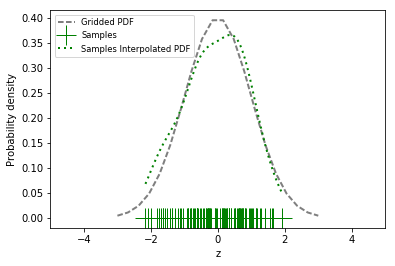

In [11]:
grid = np.linspace(-3., 3., 20)
gridded = P.evaluate(grid, using='truth', vb=False)

G = qp.PDF(gridded=gridded, limits=demo_limits)
G.sample(100, vb=False)
G.plot()

Let's unpack this a little. The `G` PDF object has an attribute `G.gridded` which contains the initial gridded function. This lookup table is used when making further approximations. To check this, let's look at whether this `G` PDF object knows what the _true_ PDF is, which approximation it's going to use, and then how it performs at making a new approximation to the PDF on a coarser grid:

In [12]:
print G.truth

None


In [13]:
print G.last,'approximation, ', G.scheme, 'interpolation'

samples approximation,  linear interpolation


In [14]:
# 10-point grid for a coarse approximation:
coarse_grid = np.linspace(-3.5, 3.5, 10)
coarse_evaluation = G.approximate(coarse_grid, using='gridded')
print coarse_evaluation

Created a `linear` interpolator for the gridded parametrization.
interpolating between -3.5 and 3.5 using gridded
(array([-3.5       , -2.72222222, -1.94444444, -1.16666667, -0.38888889,
        0.38888889,  1.16666667,  1.94444444,  2.72222222,  3.5       ]), array([  2.22044605e-16,   1.01276268e-02,   6.23293197e-02,
         2.03331828e-01,   3.67719426e-01,   3.67719426e-01,
         2.03331828e-01,   6.23293197e-02,   1.01276268e-02,
         2.22044605e-16]))


### Mixture Model Fit

We can fit a parametric mixture model to samples from any parametrization.  Currently, only a Gaussian mixture model is supported.

(array([ 0.27117763,  0.10166441,  0.28211746,  0.13060918,  0.21443132]), array([ 0.68162999, -1.58398141, -0.07572552,  1.50491781, -0.76975602]), array([ 0.3518439 ,  0.56695242,  0.30258794,  0.56609536,  0.34376096]))
0.271177632455$\cdot\mathcal{N}($0.681629992864,0.351843902926)\n0.101664411606$\cdot\mathcal{N}($-1.58398141195,0.566952416627)\n0.282117456745$\cdot\mathcal{N}($-0.0757255185768,0.302587938283)\n0.130609179256$\cdot\mathcal{N}($1.50491781334,0.566095357936)\n0.214431319938$\cdot\mathcal{N}($-0.769756015258,0.343760957417)\n
Plotted truth.
Plotted mixture model.
Created a KDE interpolator for the samples parametrization.
interpolating between -3.01951215582 and 3.19310756784 using samples
Plotted samples


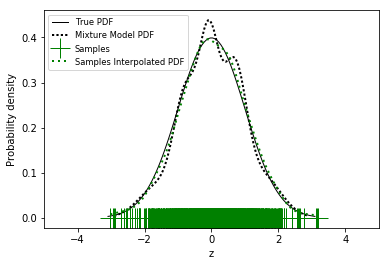

In [15]:
MM = qp.PDF(truth=dist, limits=demo_limits)
MM.sample(1000, vb=False)
MM.mix_mod_fit(n_components=5)
MM.plot()

## Comparing Parametrizations

`qp` supports both qualitative and quantitative comparisons between different distributions, across parametrizations.

### Qualitative Comparisons: Plotting

Let's visualize the PDF object in order to compare the truth and the approximations.  The solid, black line shows the true PDF evaluated between the bounds.  The green rugplot shows the locations of the 1000 samples we took.  The vertical, dotted, blue lines show the percentiles we asked for, and the hotizontal, dotted, red lines show the 10 equally spaced bins we asked for.  Note that the quantiles refer to the probability distribution *between the bounds*, because we are not able to integrate numerically over an infinite range. Interpolations of each parametrization are given as dashed lines in their corresponding colors.  Note that the interpolations of the quantile and histogram parametrizations are so close to each other that the difference is almost imperceptible!

Plotted truth.
interpolating between -1.33517773612 and 1.33517773612 using quantiles
interpolating between -5.0 and 5.0 using quantiles
Plotted quantiles.
Created a piecewise constant interpolator for the histogram parametrization.
interpolating between -5.0 and 5.0 using histogram
Plotted histogram.
Created a KDE interpolator for the samples parametrization.
interpolating between -3.24126734007 and 3.85273149065 using samples
Plotted samples


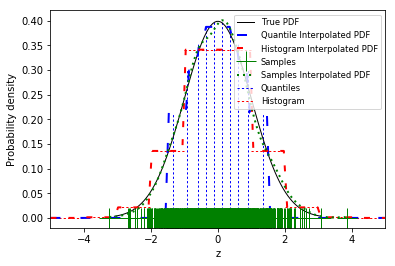

In [16]:
P.plot()

### Quantitative Comparisons

Next, let's compare the different parametrizations to the truth using the Kullback-Leibler Divergence (KLD).  The KLD is a measure of how close two probability distributions are to one another -- a smaller value indicates closer agreement.  It is measured in units of bits of information, the information lost in going from the second distribution to the first distribution.  The KLD calculator here takes in a shared grid upon which to evaluate the true distribution and the interpolated approximation of that distribution and returns the KLD of the approximation relative to the truth, which is not in general the same as the KLD of the truth relative to the approximation.  Below, we'll calculate the KLD of the approximation relative to the truth over different ranges, showing that it increases as it includes areas where the true distribution and interpolated distributions diverge.

In [17]:
qD1 = qp.utils.calculate_kl_divergence(P, Q, limits=(-1.,1.), vb=False)
qD2 = qp.utils.calculate_kl_divergence(P, Q, limits=(-2.,2.), vb=False)
qD3 = qp.utils.calculate_kl_divergence(P, Q, limits=(-3.,3.), vb=False)

hD1 = qp.utils.calculate_kl_divergence(P, H, limits=(-1.,1.), vb=False)
hD2 = qp.utils.calculate_kl_divergence(P, H, limits=(-2.,2.), vb=False)
hD3 = qp.utils.calculate_kl_divergence(P, H, limits=(-3.,3.), vb=False)

sD1 = qp.utils.calculate_kl_divergence(P, S, limits=(-1.,1.), vb=False)
sD2 = qp.utils.calculate_kl_divergence(P, S, limits=(-2.,2.), vb=False)
sD3 = qp.utils.calculate_kl_divergence(P, S, limits=(-3.,3.), vb=False)

print 'Quantile approximation: KLD over 1,2,3 sigma ranges = ', qD1, qD2, qD3
print 'Histogram approximation: KLD over 1,2,3 sigma ranges = ', hD1, hD2, hD3
print 'Sampled approximation: KLD over 1,2,3 sigma ranges = ', sD1, sD2, sD3

Quantile approximation: KLD over 1,2,3 sigma ranges =  0.0106722581206 0.288792793085 1.64392421026
Histogram approximation: KLD over 1,2,3 sigma ranges =  0.0 0.0 0.0
Sampled approximation: KLD over 1,2,3 sigma ranges =  0.0112455998462 0.0291782544635 0.0399728802287


The progression of KLD values should follow that of the root mean square error (RMSE), another measure of how close two functions are to one another.  The RMSE also increases as it includes areas where the true distribution and interpolated distribution diverge.  Unlike the KLD, the RMSE is symmetric, meaning the distance measured is not that of one distribution from the other but of the symmetric distance between them.

In [18]:
qRMSE1 = qp.utils.calculate_rmse(P, Q, limits=(-1.,1.), vb=False)
qRMSE2 = qp.utils.calculate_rmse(P, Q, limits=(-2.,2.), vb=False)
qRMSE3 = qp.utils.calculate_rmse(P, Q, limits=(-3.,3.), vb=False)

hRMSE1 = qp.utils.calculate_rmse(P, H, limits=(-1.,1.), vb=False)
hRMSE2 = qp.utils.calculate_rmse(P, H, limits=(-2.,2.), vb=False)
hRMSE3 = qp.utils.calculate_rmse(P, H, limits=(-3.,3.), vb=False)

sRMSE1 = qp.utils.calculate_rmse(P, S, limits=(-1.,1.), vb=False)
sRMSE2 = qp.utils.calculate_rmse(P, S, limits=(-2.,2.), vb=False)
sRMSE3 = qp.utils.calculate_rmse(P, S, limits=(-3.,3.), vb=False)

print 'Quantile approximation: RMSE over 1,2,3 sigma ranges = ', qRMSE1, qRMSE2, qRMSE3
print 'Histogram approximation: RMSE over 1,2,3 sigma ranges = ', hRMSE1, hRMSE2, hRMSE3
print 'Sampled approximation: RMSE over 1,2,3 sigma ranges = ', sRMSE1, sRMSE2, sRMSE3

Quantile approximation: RMSE over 1,2,3 sigma ranges =  0.0481977535893 0.0620778938517 0.0523760994392
Histogram approximation: RMSE over 1,2,3 sigma ranges =  0.0 0.0 0.0
Sampled approximation: RMSE over 1,2,3 sigma ranges =  0.0491201601032 0.0493607350595 0.0413594366449


Both the KLD and RMSE metrics suggest that the quantile approximation is better in the high density region, but samples work better when the tails are included. We might expect the answer to the question of which approximation to use to depend on the application, and whether the tails need to be captured or not.

Finally, we can compare the meoments of each approximation and compare those to the moments ofthe true distribution.

In [19]:
pdfs = [P, Q, H, S]
which_moments = range(3)
all_moments = []
for pdf in pdfs:
    moments = []
    for n in which_moments:
        moments.append(qp.utils.calculate_moment(pdf, n))
    all_moments.append(moments)
    
print('moments: '+str(which_moments))
for i in range(len(pdfs)):
    print(pdfs[i].first+': '+str(all_moments[i]))

moments: [0, 1, 2]
truth: [0.33772035859044552, 0.15503858599610643, 0.098598452329478323]
quantiles: [0.33585056202075408, 0.15430053689003803, 0.098192081169964238]
histogram: [0.33793149234504449, 0.16896574617252227, 0.11321854420403703]
samples: [0.33962518585735924, 0.15444209038535087, 0.097259964764450091]


The first three moments have an interesting interpretation.  The zeroth moment should always be 1 when calculated over the entire range of redshifts, but the quantile approximation is off by about $7\%$.  We know the first moment in this case is 0, and indeed the evaluation of the first moment for the true distribution deviates from 0 by less than Python's floating point precision.  The samples parametrization has a biased estimate for the first moment to the tune of $2\%$.  The second moment for the true distribution is 1, and the quantile parametrization (and, to a lesser extent, the histogram parametrization) fails to provide a good estimate of it.

## Advanced Usage

### Composite PDFs

In addition to individual `scipy.stats.rv_continuous` objects, `qp` can be initialized with true distributions that are linear combinations of `scipy.stats.rv_continuous` objects.  To do this, one must create the component distributions and specify their relative weights.  This can be done by running `qp.PDF.mix_mod_fit()` on an existing `qp.PDF` object once samples have been calculated, or it can be done by hand.

Plotted truth.


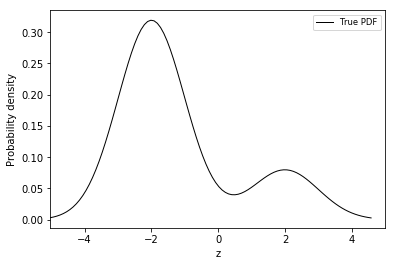

In [25]:
component_1 = {}
component_1['function'] = sps.norm(loc=-2., scale=1.)
component_1['coefficient'] = 4.
component_2 = {}
component_2['function'] = sps.norm(loc=2., scale=1.)
component_2['coefficient'] = 1.
dist_info = [component_1, component_2]

composite_lims = (-5., 5.)

C_dist = qp.composite(dist_info)
C = qp.PDF(truth=C_dist, limits=composite_lims)
C.plot()

We can calculate the quantiles for such a distribution.

In [26]:
Cq = qp.PDF(truth=C_dist, limits = composite_lims)
Cq.quantize(N=20, limits=composite_lims, vb=False)
Cq.plot()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Similarly, the histogram parametrization is also supported for composite PDFs.

Calculating histogram:  [-5.  -4.5 -4.  -3.5 -3.  -2.5 -2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5  2.
  2.5  3.   3.5  4.   4.5  5. ]
Result:  (array([-5. , -4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,
        0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ]), array([ 0.00778614,  0.02650052,  0.0705866 ,  0.14715564,  0.24013706,
        0.30676535,  0.30683452,  0.24058333,  0.14910206,  0.07721173,
        0.04414717,  0.04457502,  0.061824  ,  0.07701047,  0.07673381,
        0.06003894,  0.03678931,  0.01764668,  0.00662513,  0.00194653]))
Plotted truth.
Created a piecewise constant interpolator for the histogram parametrization.
interpolating between -5.0 and 5.0 using histogram
Plotted histogram.


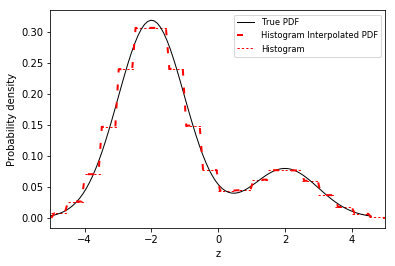

In [27]:
Ch = qp.PDF(truth=C_dist, limits = composite_lims)
Ch.histogramize(N=20, binrange=composite_lims, vb=True)
Ch.plot()

Finally, samples from this distribution may also be taken, and a PDF may be reconstructed from them.  Note: this uses `scipy.stats.gaussian_kde`, which determines its bandwidth/kernel size using [Scott's Rule](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html), which clearly leaves something to be desired! 

Plotted truth.
Created a KDE interpolator for the samples parametrization.
interpolating between -4.40734420698 and 3.07426761291 using samples
Plotted samples


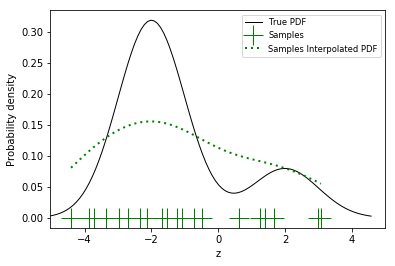

In [28]:
Cs = qp.PDF(truth=C_dist, limits = composite_lims)
Cs.sample(N=20, vb=False)
Cs.plot()

In [29]:
qD = qp.utils.calculate_kl_divergence(C, Cq, limits=composite_lims, dx=0.001, vb=True)
hD = qp.utils.calculate_kl_divergence(C, Ch, limits=composite_lims, dx=0.001, vb=True)
sD = qp.utils.calculate_kl_divergence(C, Cs, limits=composite_lims, dx=0.001, vb=True)
print(qD, hD, sD)

Evaluating the true distribution.
Evaluating the true distribution.
Evaluating the true distribution.
Created a piecewise constant interpolator for the histogram parametrization.
interpolating between -5.0 and 4.999 using histogram
Evaluating the true distribution.
Created a KDE interpolator for the samples parametrization.
interpolating between -5.0 and 4.999 using samples
(0.0, 0.03615845773915094, 0.16818348190146157)
